In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
from NEF_WM import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Carrabin

In [2]:
seed_net = 0
sid = 1
trial = 1
alpha = 0.15
z = 0
n_error = 200
n_memory = 200

env = EnvironmentWM(dataset="carrabin", sid=sid, trial=trial, alpha=alpha, z=z)
net, sim = simulate_WM(env=env, n_memory=n_memory, n_error=n_error, seed_net=seed_net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

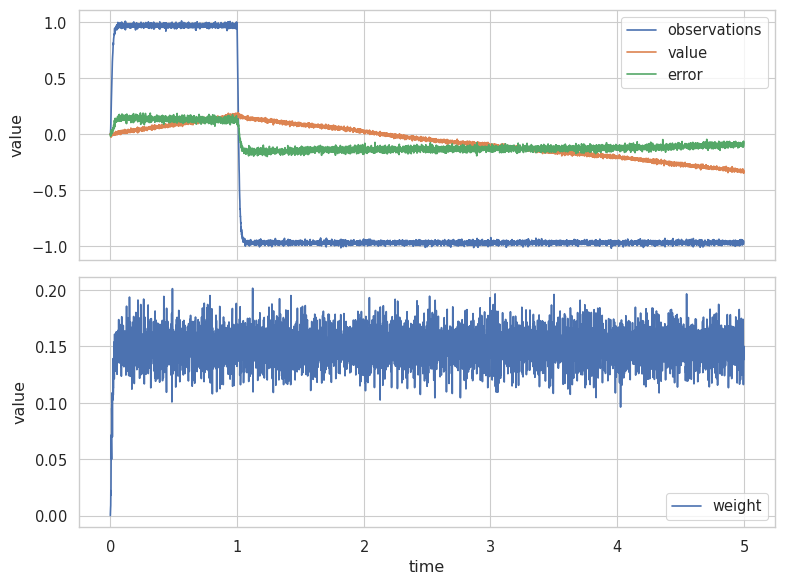

In [3]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
obs_times = np.arange(0, 6*env.T, env.T)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
    sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
    sns.lineplot(x=times, y=value, ax=axes[0], label='value')
    sns.lineplot(x=times, y=error, ax=axes[0], label='error')
    sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
    axes[0].set(xlabel='time', ylabel='value')
    axes[1].set(xlabel='time', ylabel='value', xticks=obs_times)
    plt.tight_layout()

# Jiang

In [4]:
trial = 1
sid = 1
alpha = 0.2
z = 0.5
n_error = 200
n_memory = 200

env = EnvironmentWM(dataset='jiang', sid=sid, trial=trial, alpha=alpha, z=z)
net, sim = simulate_WM(env=env, n_memory=n_memory, n_error=n_error, seed_net=sid, progress_bar=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [5]:
def cumulative_average(a):
    return np.cumsum(a) / np.arange(1, len(a) + 1)

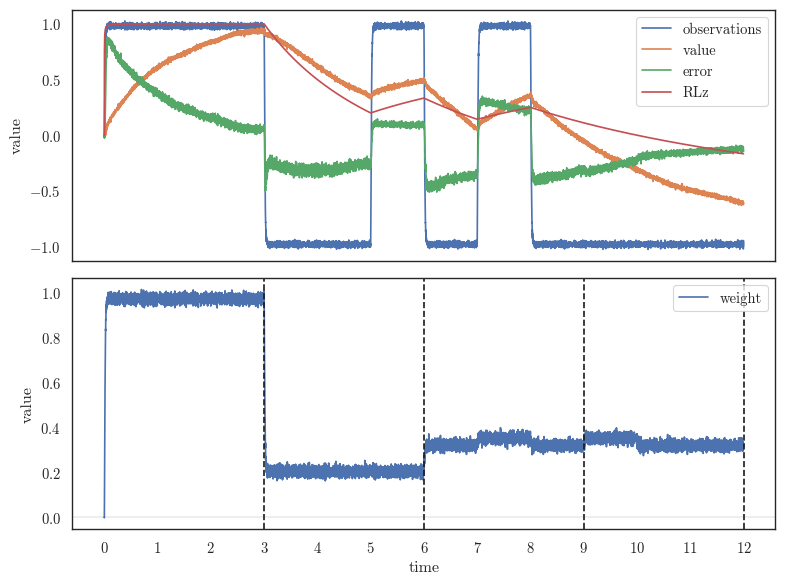

In [6]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
cumavg = cumulative_average(input_obs)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=value, ax=axes[0], label='value')
sns.lineplot(x=times, y=error, ax=axes[0], label='error')
sns.lineplot(x=times, y=cumavg, ax=axes[0], label='RLz')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(3*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+2*env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+3*env.n_neighbors*env.T, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+4*env.n_neighbors*env.T, env.T))  # , ylim=(0.0, 0.5)
plt.tight_layout()